In [1]:
import matplotlib.pyplot as plt 
import pandas as pd 
from sklearn.model_selection import train_test_split
import seaborn as sns
import re
from konlpy.tag import Kkma
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
import sklearn
import pickle as pickle


/opt/conda/lib/python3.8/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [46]:
pred = pd.read_csv('../code/prediction/dev_train_half_arg.csv')
labels = pd.read_csv('../data/dataset/train/dev_no_half_arg_equal.csv')
labels.id=labels.index
labels.head()

,Unnamed: 0,id,sentence,subject_entity,object_entity,label,source
0,25543,0,는 지난 16일 한국철도공사를 방문해 손병석 사장에게 전라선 KTX 증편과 동력분산...,"{'word': '한국철도공사', 'start_idx': 9, 'end_idx': ...","{'word': '손병석', 'start_idx': 21, 'end_idx': 23...",org:top_members/employees,wikitree
1,14789,1,"프레디 머큐리가 작곡한 곡들로 〈Bohemian Rhapsody〉, 〈We Are ...","{'word': '프레디 머큐리', 'start_idx': 0, 'end_idx':...","{'word': 'Killer Queen', 'start_idx': 136, 'en...",per:product,wikipedia
2,7185,2,"지난 4일 방송된 SBS '동상이몽-너는 내 운명'에서는 최수종, 하희라 씨 부부가...","{'word': '최수종', 'start_idx': 32, 'end_idx': 34...","{'word': '하희라', 'start_idx': 37, 'end_idx': 39...",per:spouse,wikitree
3,12313,3,"이날 이찬혁·이수현 씨 남매는 군대로 인해 떨어진 기간 동안 느꼈던 점, 목표 등에...","{'word': '이찬혁', 'start_idx': 3, 'end_idx': 5, ...","{'word': '이수현', 'start_idx': 7, 'end_idx': 9, ...",per:siblings,wikitree
4,31372,4,프란츠 카프카는 오스트리아-헝가리 제국의 유대계 소설가이다.,"{'word': '카프카', 'start_idx': 4, 'end_idx': 6, ...","{'word': '오스트리아-헝가리 제국', 'start_idx': 9, 'end_...",per:origin,wikipedia


In [43]:
def whatType(string):
    dic = eval(string)
    return dic['type']
def whatIsWord(string):
    dic = eval(string)
    return dic['word']
def when_start(ob_entity,sub_entity):
    ob_idx = eval(ob_entity)['start_idx']
    sub_idx = eval(sub_entity)['start_idx']
    if ob_idx >sub_idx:
        return 0
    return 1

In [47]:
pred = pd.read_csv('../code/prediction/dev_train_half_arg.csv')
labels = pd.read_csv('../data/dataset/train/dev_no_half_arg_equal.csv')
labels.id=labels.index
labels['object_type'] = labels.object_entity.apply(lambda x: whatType(x))
labels['subject_type'] = labels.subject_entity.apply(lambda x: whatType(x))
labels['fast']= labels.id.apply(lambda x: when_start(labels['object_entity'].loc[x],labels['subject_entity'].loc[x]))


In [48]:
labels.head()

,Unnamed: 0,id,sentence,subject_entity,object_entity,label,source,object_type,subject_type,fast
0,25543,0,는 지난 16일 한국철도공사를 방문해 손병석 사장에게 전라선 KTX 증편과 동력분산...,"{'word': '한국철도공사', 'start_idx': 9, 'end_idx': ...","{'word': '손병석', 'start_idx': 21, 'end_idx': 23...",org:top_members/employees,wikitree,PER,ORG,0
1,14789,1,"프레디 머큐리가 작곡한 곡들로 〈Bohemian Rhapsody〉, 〈We Are ...","{'word': '프레디 머큐리', 'start_idx': 0, 'end_idx':...","{'word': 'Killer Queen', 'start_idx': 136, 'en...",per:product,wikipedia,POH,PER,0
2,7185,2,"지난 4일 방송된 SBS '동상이몽-너는 내 운명'에서는 최수종, 하희라 씨 부부가...","{'word': '최수종', 'start_idx': 32, 'end_idx': 34...","{'word': '하희라', 'start_idx': 37, 'end_idx': 39...",per:spouse,wikitree,PER,PER,0
3,12313,3,"이날 이찬혁·이수현 씨 남매는 군대로 인해 떨어진 기간 동안 느꼈던 점, 목표 등에...","{'word': '이찬혁', 'start_idx': 3, 'end_idx': 5, ...","{'word': '이수현', 'start_idx': 7, 'end_idx': 9, ...",per:siblings,wikitree,PER,PER,0
4,31372,4,프란츠 카프카는 오스트리아-헝가리 제국의 유대계 소설가이다.,"{'word': '카프카', 'start_idx': 4, 'end_idx': 6, ...","{'word': '오스트리아-헝가리 제국', 'start_idx': 9, 'end_...",per:origin,wikipedia,ORG,PER,0


In [4]:


def label_to_num(label):
  num_label = []
  with open('../code/dict_label_to_num.pkl', 'rb') as f:
    dict_label_to_num = pickle.load(f)
  for v in label:
    num_label.append(dict_label_to_num[v])
  
  return num_label

In [5]:
compare = pd.concat([labels[['id','label']],pred.pred_label],axis=1)
compare['label'] = label_to_num(compare.label.values)
compare['pred_label'] = label_to_num(compare.pred_label.values)
compare.head()


,id,label,pred_label
0,25543,1,1
1,14789,8,8
2,7185,17,17
3,12313,16,16
4,31372,15,15


In [6]:
compare[compare.label==compare.pred_label].shape, compare[compare.label!=compare.pred_label].shape

((499, 3), (101, 3))

<Axes: xlabel='label', ylabel='pred_label'>

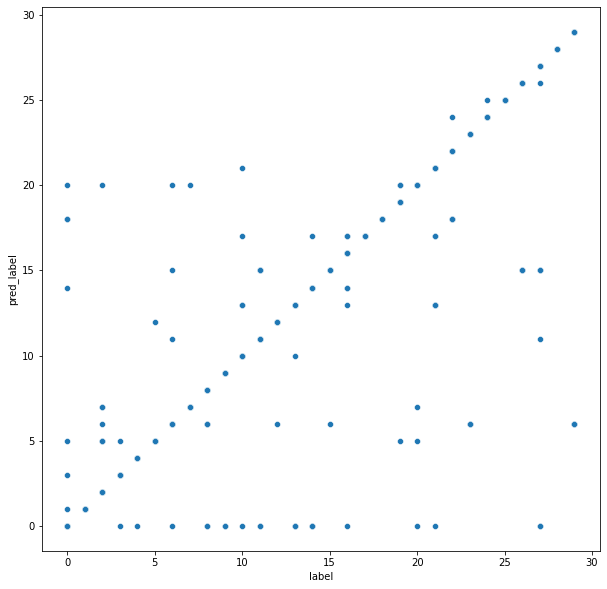

In [7]:
plt.figure(figsize=(10,10))
sns.scatterplot(x=compare.label, y= compare.pred_label)
# plt.xticks(rotation=90)

In [8]:
train_data = pd.read_csv('../data/dataset/train/train_no_half_arg_equal.csv')


<Axes: xlabel='label'>

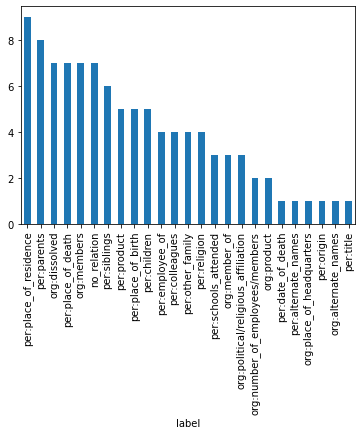

In [59]:
compare = pd.concat([labels[['id','label','subject_type','object_type','fast']],pred.pred_label],axis=1)

compare[compare.label!=compare.pred_label]['label'].value_counts().plot(kind='bar')

<Axes: xlabel='subject_type'>

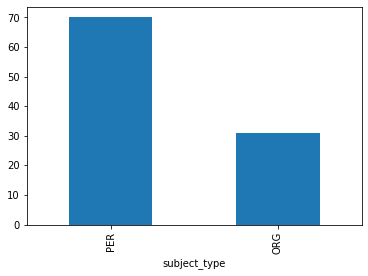

In [36]:
compare[compare.label!=compare.pred_label]['subject_type'].value_counts().plot(kind='bar')


<Axes: xlabel='subject_type'>

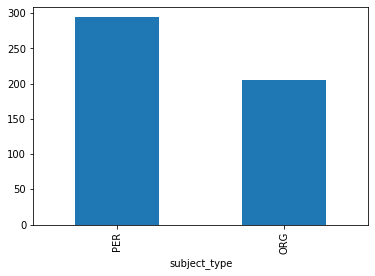

In [49]:
compare[compare.label ==compare.pred_label]['subject_type'].value_counts().plot(kind='bar')


<Axes: xlabel='subject_type'>

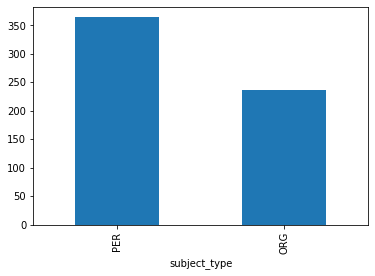

In [50]:
compare['subject_type'].value_counts().plot(kind='bar')


<Axes: xlabel='object_type'>

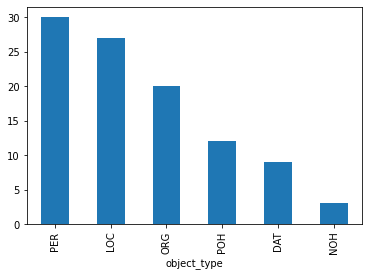

In [51]:
compare[compare.label!=compare.pred_label]['object_type'].value_counts().plot(kind='bar')


<Axes: xlabel='object_type'>

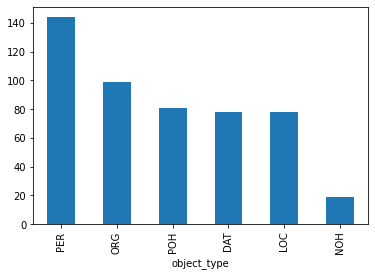

In [52]:
compare[compare.label==compare.pred_label]['object_type'].value_counts().plot(kind='bar')


In [10]:
count_train = pd.concat([train_data['label'].value_counts()/250,compare[compare.label!=compare.pred_label]['label'].value_counts(),
                         compare[compare.label!=compare.pred_label]['pred_label'].value_counts(),compare[compare.label==compare.pred_label]['pred_label'].value_counts()],axis=1)
count_train.columns=['train','val_label','val_pred','correct']
count_train.head()


,train,val_label,val_pred,correct
org:top_members/employees,19.960,NaN,1.0,20
no_relation,18.980,7.0,21.0,13
per:employee_of,17.456,4.0,13.0,16
per:title,10.920,1.0,NaN,19
org:member_of,9.460,3.0,6.0,17


<Axes: >

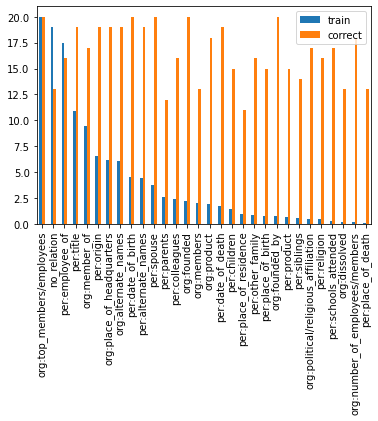

In [11]:
count_train[['train','correct']].plot(kind='bar')

<Axes: >

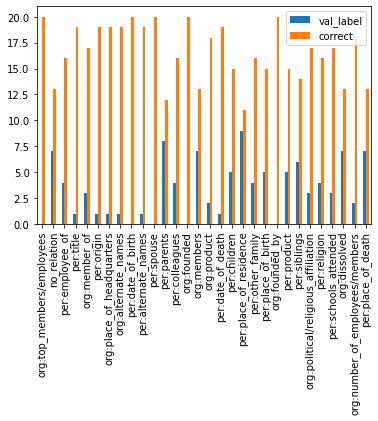

In [12]:
count_train[['val_label','correct']].plot(kind='bar')


<Axes: >

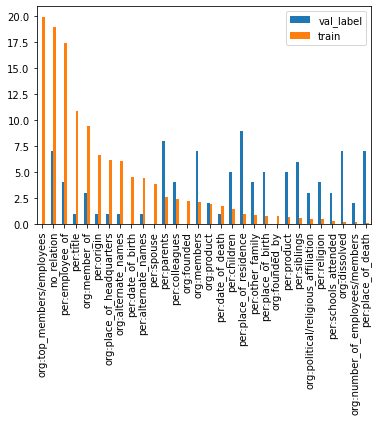

In [13]:
count_train[['val_label','train']].plot(kind='bar')


<Axes: xlabel='label'>

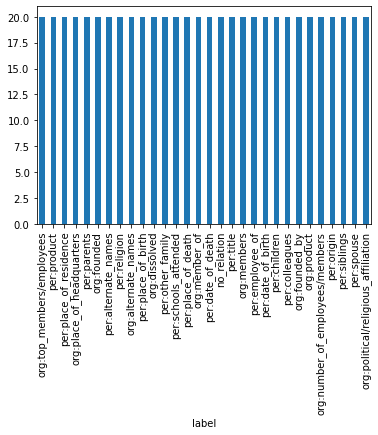

In [14]:
compare['label'].value_counts().plot(kind='bar')

In [30]:
def klue_re_micro_f1(preds, labels):
    """KLUE-RE micro f1 (except no_relation)"""
    label_list = ['no_relation', 'org:top_members/employees', 'org:members',
       'org:product', 'per:title', 'org:alternate_names',
       'per:employee_of', 'org:place_of_headquarters', 'per:product',
       'org:number_of_employees/members', 'per:children',
       'per:place_of_residence', 'per:alternate_names',
       'per:other_family', 'per:colleagues', 'per:origin', 'per:siblings',
       'per:spouse', 'org:founded', 'org:political/religious_affiliation',
       'org:member_of', 'per:parents', 'org:dissolved',
       'per:schools_attended', 'per:date_of_death', 'per:date_of_birth',
       'per:place_of_birth', 'per:place_of_death', 'org:founded_by',
       'per:religion']
    no_relation_label_idx = label_list.index("no_relation")
    preds = label_to_num(preds.values)
    labels = label_to_num(labels.values)

    label_indices = list(range(len(label_list)))
    label_indices.remove(no_relation_label_idx)
    return sklearn.metrics.f1_score(labels, preds, average="micro", labels=label_indices) * 100.0


def label_to_num(label):
  num_label = []
  with open('../code/dict_label_to_num.pkl', 'rb') as f:
    dict_label_to_num = pickle.load(f)
  for v in label:
    num_label.append(dict_label_to_num[v])
  
  return num_label

In [27]:
compare.head()


,id,label,pred_label
0,25543,org:top_members/employees,org:top_members/employees
1,14789,per:product,per:product
2,7185,per:spouse,per:spouse
3,12313,per:siblings,per:siblings
4,31372,per:origin,per:origin


In [16]:
compare = pd.concat([labels[['id','label']],pred.pred_label],axis=1)
print((klue_re_micro_f1(compare.pred_label,compare.label)))

83.16666666666667


In [17]:
compare = pd.concat([labels[['id','label']],pred.pred_label],axis=1)
compare=compare[compare.label != 'no_relation']
print((klue_re_micro_f1(compare.pred_label,compare.label)))


83.79310344827586


In [18]:
compare = pd.concat([labels[['id','label']],pred.pred_label],axis=1)
compare=compare[compare.pred_label != 'no_relation']
print((klue_re_micro_f1(compare.pred_label,compare.label)))


85.86572438162544


In [19]:
def whatType(string):
    dic = eval(string)
    return dic['type']

In [20]:
test_data= pd.read_csv('../data/dataset/test/test_data.csv')
test_data['object_type'] = test_data['object_entity'].apply(lambda x: whatType(x))
test_data['subject_type'] = test_data['subject_entity'].apply(lambda x: whatType(x))

In [21]:
result = pd.read_csv('../code/prediction/train_half_arg.csv')
result['object_type']= test_data['object_type']
result['subject_type']= test_data['subject_type']
# result['pred_label'].value_counts().plot(kind='bar')
result.head()

,id,pred_label,probs,object_type,subject_type
0,0,org:alternate_names,"[0.02041192166507244, 0.005389280617237091, 0....",ORG,ORG
1,1,per:alternate_names,"[3.6237604945199564e-05, 2.641566788952332e-05...",POH,PER
2,2,no_relation,"[0.998301088809967, 3.030454354302492e-05, 7.6...",DAT,ORG
3,3,no_relation,"[0.7988805174827576, 0.00030542942113243043, 0...",PER,PER
4,4,no_relation,"[0.7109772562980652, 0.23348800837993622, 0.00...",PER,ORG


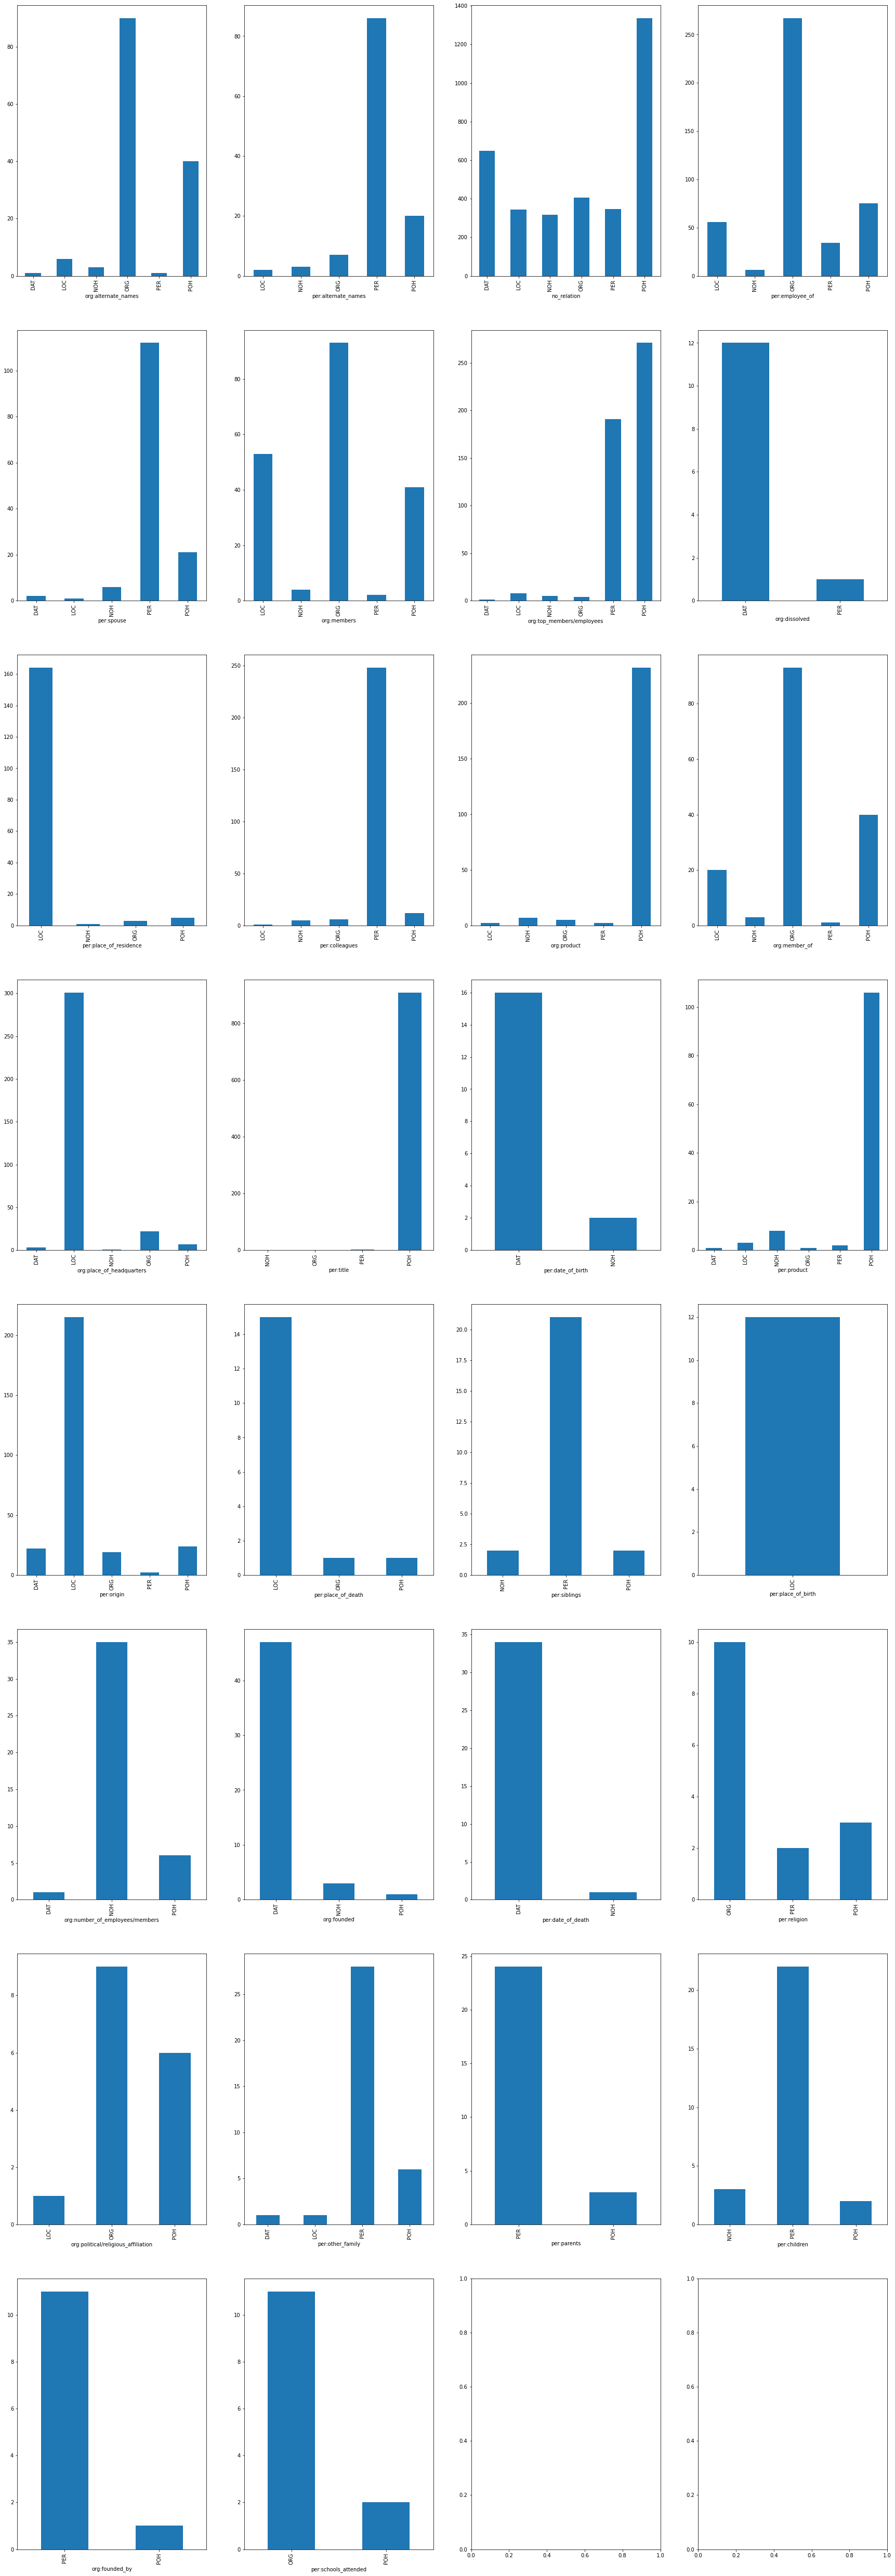

In [22]:
fig, axes = plt.subplots(8, 4, figsize=(30, 90))
axes= axes.flatten()

for num, label in enumerate(result.pred_label.unique()):
    result[result.pred_label == label].groupby(['object_type']).count().id.plot(kind='bar',ax=axes[num])
    axes[num].set_xlabel(label)

In [23]:
result.pred_label.unique()[0]

'org:alternate_names'

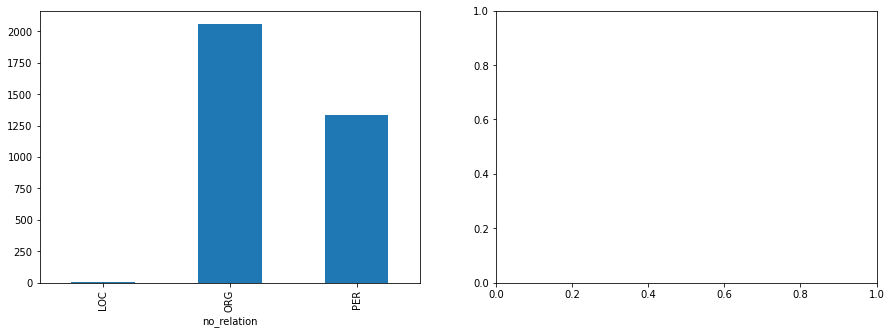

In [24]:
fig, axes = plt.subplots(1,2, figsize=(15,5))
axes= axes.flatten()

for num, label in enumerate(['no_relation']):
    result[result.pred_label == label].groupby(['subject_type']).count().id.plot(kind='bar',ax=axes[num])
    axes[num].set_xlabel(label)

In [25]:
test_data[(test_data.subject_type != 'ORG') & (test_data.subject_type != 'PER')]

,id,sentence,subject_entity,object_entity,label,source,object_type,subject_type
6820,6820,"1875년 시카고 빈민가에 교회를 설립했는데, 구두판매원출신다운 쉽고 설득력있는 무...","{'word': '시카고', 'start_idx': 6, 'end_idx': 8, ...","{'word': '1875년', 'start_idx': 0, 'end_idx': 4...",100,wikipedia,DAT,LOC


In [26]:
compare[compare['id']==6820]

,id,label,pred_label


In [28]:
compare_no_rel = compare.copy()
compare_no_rel.pred_label = 'no_relation'

In [29]:
compare_no_rel

,id,label,pred_label
0,25543,org:top_members/employees,no_relation
1,14789,per:product,no_relation
2,7185,per:spouse,no_relation
3,12313,per:siblings,no_relation
4,31372,per:origin,no_relation
...,...,...,...
595,8230,per:place_of_birth,no_relation
596,22170,org:member_of,no_relation
597,22857,org:founded,no_relation
598,13106,per:spouse,no_relation


In [31]:
print((klue_re_micro_f1(compare_no_rel.pred_label,compare_no_rel.label)))

0.0


In [55]:
for i in compare.object_type.unique():
    print(i, klue_re_micro_f1(compare[compare.object_type==i].pred_label,compare[compare.object_type==i].label))

PER 85.45994065281899
POH 90.05847953216374
ORG 83.76068376068375
NOH 90.0
DAT 90.12345679012346
LOC 75.24752475247524


In [56]:
for i in compare.subject_type.unique():
    print(i, klue_re_micro_f1(compare[compare.subject_type==i].pred_label,compare[compare.subject_type==i].label))

ORG 87.98185941043084
PER 82.83687943262412


In [60]:
for i in compare.fast.unique():
    print(i, klue_re_micro_f1(compare[compare.fast==i].pred_label,compare[compare.fast==i].label))

0 86.29737609329446
1 82.6086956521739


In [68]:
train_data = pd.read_csv('../data/dataset/train/train.csv')
train_data2 = train_data.copy()
train_data2['object_type'] = train_data2.object_entity.apply(lambda x: whatType(x))
train_data2['subject_type'] = train_data2.subject_entity.apply(lambda x: whatType(x))
train_data2['fast']= train_data2.id.apply(lambda x: when_start(train_data2['object_entity'].loc[x],train_data2['subject_entity'].loc[x]))

train_data2.head()

,id,sentence,subject_entity,object_entity,label,source,object_type,subject_type,fast
0,0,〈Something〉는 조지 해리슨이 쓰고 비틀즈가 1969년 앨범 《Abbey R...,"{'word': '비틀즈', 'start_idx': 24, 'end_idx': 26...","{'word': '조지 해리슨', 'start_idx': 13, 'end_idx':...",no_relation,wikipedia,PER,ORG,1
1,1,호남이 기반인 바른미래당·대안신당·민주평화당이 우여곡절 끝에 합당해 민생당(가칭)으...,"{'word': '민주평화당', 'start_idx': 19, 'end_idx': ...","{'word': '대안신당', 'start_idx': 14, 'end_idx': 1...",no_relation,wikitree,ORG,ORG,1
2,2,K리그2에서 성적 1위를 달리고 있는 광주FC는 지난 26일 한국프로축구연맹으로부터...,"{'word': '광주FC', 'start_idx': 21, 'end_idx': 2...","{'word': '한국프로축구연맹', 'start_idx': 34, 'end_idx...",org:member_of,wikitree,ORG,ORG,0
3,3,균일가 생활용품점 (주)아성다이소(대표 박정부)는 코로나19 바이러스로 어려움을 겪...,"{'word': '아성다이소', 'start_idx': 13, 'end_idx': ...","{'word': '박정부', 'start_idx': 22, 'end_idx': 24...",org:top_members/employees,wikitree,PER,ORG,0
4,4,1967년 프로 야구 드래프트 1순위로 요미우리 자이언츠에게 입단하면서 등번호는 8...,"{'word': '요미우리 자이언츠', 'start_idx': 22, 'end_id...","{'word': '1967', 'start_idx': 0, 'end_idx': 3,...",no_relation,wikipedia,DAT,ORG,1


In [65]:
for i in compare.fast.unique():
    for j in compare.subject_type.unique():
        for k in compare.object_type.unique():
            x= compare[(compare.fast==i) & (compare.subject_type==j) & (compare.object_type==k)]
            print(f'{i} - {j} - {k}',x.shape[0], klue_re_micro_f1(x.pred_label, x.label))

0 - ORG - PER 23 100.0
0 - ORG - POH 26 91.30434782608695
0 - ORG - ORG 37 83.33333333333334
0 - ORG - NOH 17 96.96969696969697
0 - ORG - DAT 13 85.71428571428572
0 - ORG - LOC 14 92.3076923076923
0 - PER - PER 69 81.203007518797
0 - PER - POH 27 93.87755102040816
0 - PER - ORG 35 88.57142857142857
0 - PER - NOH 1 0.0
0 - PER - DAT 34 100.0
0 - PER - LOC 61 71.66666666666666
1 - ORG - PER 17 94.11764705882352
1 - ORG - POH 20 91.8918918918919
1 - ORG - ORG 19 83.33333333333333
1 - ORG - NOH 4 80.0
1 - ORG - DAT 33 78.68852459016394
1 - ORG - LOC 13 75.0
1 - PER - PER 65 82.25806451612904
1 - PER - POH 20 82.05128205128204
1 - PER - ORG 28 78.57142857142857
1 - PER - NOH 0 0.0
1 - PER - DAT 7 100.0
1 - PER - LOC 17 75.00000000000001


/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1495: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(


In [93]:
# for i in compare.fast.unique():
for j in compare.subject_type.unique():
    for k in compare.object_type.unique():
        x= compare[(compare.object_type==k) & (compare.subject_type==j)]
        print(f'{j} - {k}',x.shape[0], klue_re_micro_f1(x.pred_label, x.label))

ORG - PER 40 97.5
ORG - POH 46 91.56626506024097
ORG - ORG 56 83.33333333333334
ORG - NOH 21 94.73684210526316
ORG - DAT 46 80.48780487804876
ORG - LOC 27 83.99999999999999
PER - PER 134 81.71206225680933
PER - POH 47 88.63636363636364
PER - ORG 63 84.12698412698413
PER - NOH 1 0.0
PER - DAT 41 100.0
PER - LOC 78 72.36842105263159


In [103]:
# for i in compare.fast.unique():
for j in compare.subject_type.unique():
    for k in compare.object_type.unique():
        x= compare[(compare.object_type==k) & (compare.subject_type==j)]
        score = klue_re_micro_f1(x.pred_label, x.label)
        if score <50:
            print(f'{j} - {k}',x.shape[0], score)

PER - NOH 1 0.0


In [107]:
for i in compare.fast.unique():
    for j in compare.subject_type.unique():
        for k in compare.object_type.unique():
            x= compare[(compare.fast==i) & (compare.subject_type==j) & (compare.object_type==k)]

            score = klue_re_micro_f1(x.pred_label, x.label)
            if score <50:
                print(f'{i} - {j} - {k}',x.shape[0], score)

0 - PER - NOH 1 0.0
1 - PER - NOH 0 0.0


/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1495: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(


In [106]:
for i in compare.fast.unique():
    for j in compare.subject_type.unique():
        for k in compare.object_type.unique():
            x= train_data2[(train_data2.fast==i) & (train_data2.subject_type==j) & (train_data2.object_type==k)]
            print(f'{i} - {j} - {k}',x.shape[0])

0 - ORG - PER 3043
0 - ORG - POH 921
0 - ORG - ORG 2542
0 - ORG - NOH 202
0 - ORG - DAT 651
0 - ORG - LOC 868
0 - PER - PER 2685
0 - PER - POH 1800
0 - PER - ORG 2135
0 - PER - NOH 95
0 - PER - DAT 1694
0 - PER - LOC 1085
1 - ORG - PER 1736
1 - ORG - POH 738
1 - ORG - ORG 2558
1 - ORG - NOH 58
1 - ORG - DAT 1459
1 - ORG - LOC 908
1 - PER - PER 2324
1 - PER - POH 1654
1 - PER - ORG 2111
1 - PER - NOH 58
1 - PER - DAT 445
1 - PER - LOC 700


In [102]:
dev = train_data2.groupby(['object_type','subject_type']).sample(n=20, random_state=777)
# dev = train_data2.iloc[dev_index]
train = train_data.drop(dev.index)
train= train.sample(frac=1, random_state=777)
print(dev.shape,train.shape)
dev.to_csv('../data/dataset/train/dev_type.csv')
train.to_csv('../data/dataset/train/train_type.csv')

(240, 9) (32230, 6)


In [82]:
for i in dev.fast.unique():
    for j in dev.subject_type.unique():
        for k in dev.object_type.unique():
            x= dev[(dev.fast==i) & (dev.subject_type==j) & (dev.object_type==k)]
            print(f'{i} - {j} - {k}',x.shape[0])
            

0 - ORG - DAT 195
0 - ORG - LOC 261
0 - ORG - NOH 60
0 - ORG - ORG 763
0 - ORG - PER 913
0 - ORG - POH 276
0 - PER - DAT 507
0 - PER - LOC 327
0 - PER - NOH 30
0 - PER - ORG 641
0 - PER - PER 806
0 - PER - POH 540
1 - ORG - DAT 437
1 - ORG - LOC 272
1 - ORG - NOH 18
1 - ORG - ORG 768
1 - ORG - PER 520
1 - ORG - POH 222
1 - PER - DAT 133
1 - PER - LOC 211
1 - PER - NOH 18
1 - PER - ORG 634
1 - PER - PER 697
1 - PER - POH 496


In [91]:
train_data2.groupby(['label','object_type','subject_type','fast']).count().id.min()

1

In [116]:
pred2 = pd.read_csv('../code/prediction/dev_train_changeword_type.csv')
labels2 = pd.read_csv('../data/dataset/train/dev_type.csv')
# labels2.head()
labels2.id=labels2.index
labels2['object_type'] = labels2.object_entity.apply(lambda x: whatType(x))
labels2['subject_type'] = labels2.subject_entity.apply(lambda x: whatType(x))
labels2['fast']= labels2.id.apply(lambda x: when_start(labels2['object_entity'].loc[x],labels2['subject_entity'].loc[x]))
labels2.head()
compare2 = pd.concat([labels2[['id','label','subject_type','object_type','fast']],pred2.pred_label],axis=1)


,Unnamed: 0,id,sentence,subject_entity,object_entity,label,source,object_type,subject_type,fast
0,2769,0,1997년 그와 함께 뉴욕 메츠에 입단했으나 부상으로 1999년에 방출된 이후 여러...,"{'word': '뉴욕 메츠', 'start_idx': 12, 'end_idx': ...","{'word': '1999년', 'start_idx': 30, 'end_idx': ...",no_relation,wikipedia,DAT,ORG,0
1,25687,1,삼성 라이온즈에서만 현역 생활을 하다가 은퇴한 박승호는 1993년부터 1999년까지...,"{'word': '삼성 라이온즈', 'start_idx': 0, 'end_idx':...","{'word': '1999년', 'start_idx': 39, 'end_idx': ...",no_relation,wikipedia,DAT,ORG,0
2,11797,2,서울과학기술대학교는 1909년 대한제국 순종황제의 실업학교령(칙령 제56호)이 반포...,"{'word': '서울과학기술대학교', 'start_idx': 0, 'end_idx...","{'word': '1910년 4월 15일', 'start_idx': 49, 'end...",org:founded,wikipedia,DAT,ORG,0
3,4985,3,1815년 후에 네덜란드가 오라녜나사우가 아래 왕정이 될 때 어떤 위그노 가족들은 ...,"{'word': '네덜란드', 'start_idx': 9, 'end_idx': 12...","{'word': '1815년', 'start_idx': 0, 'end_idx': 4...",no_relation,wikipedia,DAT,ORG,1
4,8748,4,"동국대 체육교육학과 졸업 후 드래프트에서 지명을 받지 못했고, 동국대 체육교육학과 ...","{'word': '삼성 라이온즈', 'start_idx': 63, 'end_idx'...","{'word': '2006년', 'start_idx': 88, 'end_idx': ...",no_relation,wikipedia,DAT,ORG,0


In [122]:
for i in compare2.fast.unique():
    for j in compare2.subject_type.unique():
        for k in compare2.object_type.unique():
            x= compare2[(compare2.fast==i) & (compare2.subject_type==j) & (compare2.object_type==k)]
            print(f'{i} - {j} - {k}',x.shape[0], klue_re_micro_f1(x.pred_label, x.label))

0 - ORG - DAT 8 100.0
0 - ORG - LOC 9 50.0
0 - ORG - NOH 14 0.0
0 - ORG - ORG 13 80.0
0 - ORG - PER 10 94.73684210526316
0 - ORG - POH 10 71.42857142857143
0 - PER - DAT 17 26.66666666666667
0 - PER - LOC 10 61.53846153846154
0 - PER - NOH 14 0.0
0 - PER - ORG 15 70.0
0 - PER - PER 10 75.0
0 - PER - POH 10 66.66666666666666
1 - ORG - DAT 12 0.0
1 - ORG - LOC 11 42.857142857142854
1 - ORG - NOH 6 0.0
1 - ORG - ORG 7 40.0
1 - ORG - PER 10 71.42857142857143
1 - ORG - POH 10 54.54545454545454
1 - PER - DAT 3 0.0
1 - PER - LOC 10 30.769230769230766
1 - PER - NOH 6 66.66666666666666
1 - PER - ORG 5 57.14285714285715
1 - PER - PER 10 57.14285714285715
1 - PER - POH 10 57.14285714285715


In [126]:
for i in compare2.fast.unique():
    for j in compare2.subject_type.unique():
        for k in compare2.object_type.unique():
            x= compare2[(compare2.fast==i) & (compare2.subject_type==j) & (compare2.object_type==k)]

            score = klue_re_micro_f1(x.pred_label, x.label)
            if score <70:
                print(f'{i} - {j} - {k}',x.shape[0], score)

0 - ORG - LOC 9 50.0
0 - ORG - NOH 14 0.0
0 - PER - DAT 17 26.66666666666667
0 - PER - LOC 10 61.53846153846154
0 - PER - NOH 14 0.0
0 - PER - POH 10 66.66666666666666
1 - ORG - DAT 12 0.0
1 - ORG - LOC 11 42.857142857142854
1 - ORG - NOH 6 0.0
1 - ORG - ORG 7 40.0
1 - ORG - POH 10 54.54545454545454
1 - PER - DAT 3 0.0
1 - PER - LOC 10 30.769230769230766
1 - PER - NOH 6 66.66666666666666
1 - PER - ORG 5 57.14285714285715
1 - PER - PER 10 57.14285714285715
1 - PER - POH 10 57.14285714285715


In [129]:
for i in compare2.fast.unique():
    for j in compare2.subject_type.unique():
        for k in compare2.object_type.unique():
            x= compare2[(compare2.fast==i) & (compare2.subject_type==j) & (compare2.object_type==k)]

            score = klue_re_micro_f1(x.pred_label, x.label)
            if score >70:
                print(f'{i} - {j} - {k}',x.shape[0], score,x.label.unique())

0 - ORG - DAT 8 100.0 ['no_relation' 'org:founded']
0 - ORG - ORG 13 80.0 ['no_relation' 'org:alternate_names' 'org:members' 'org:member_of'
 'org:product']
0 - ORG - PER 10 94.73684210526316 ['org:top_members/employees']
0 - ORG - POH 10 71.42857142857143 ['no_relation' 'org:product' 'org:member_of' 'org:top_members/employees']
0 - PER - PER 10 75.0 ['per:spouse' 'per:parents' 'per:alternate_names' 'no_relation'
 'per:employee_of' 'per:other_family' 'per:children']
1 - ORG - PER 10 71.42857142857143 ['no_relation' 'org:top_members/employees' 'org:founded_by']


In [130]:
pred3 = pd.read_csv('../code/prediction/dev_train_type.csv')
labels3 = pd.read_csv('../data/dataset/train/dev_type.csv')
# labels2.head()
labels3.id=labels2.index
labels3['object_type'] = labels3.object_entity.apply(lambda x: whatType(x))
labels3['subject_type'] = labels3.subject_entity.apply(lambda x: whatType(x))
labels3['fast']= labels3.id.apply(lambda x: when_start(labels3['object_entity'].loc[x],labels3['subject_entity'].loc[x]))
labels3.head()
compare3 = pd.concat([labels3[['id','label','subject_type','object_type','fast']],pred3.pred_label],axis=1)


In [133]:
klue_re_micro_f1(compare3.pred_label, compare3.label)

77.81569965870307

In [136]:
for i in compare3.fast.unique():
    for j in compare3.subject_type.unique():
        for k in compare3.object_type.unique():
            x= compare3[(compare2.fast==i) & (compare3.subject_type==j) & (compare3.object_type==k)]

            score = klue_re_micro_f1(x.pred_label, x.label)
            if score <70:
                print(f'{i} - {j} - {k}  size : {x.shape[0]}   ', score)

0 - ORG - DAT  size : 8    66.66666666666666
0 - ORG - LOC  size : 9    66.66666666666666
0 - ORG - NOH  size : 14    50.0
0 - PER - NOH  size : 14    50.0
1 - ORG - DAT  size : 12    0.0
1 - ORG - LOC  size : 11    53.333333333333336
1 - ORG - ORG  size : 7    50.0
1 - ORG - POH  size : 10    61.53846153846153
1 - PER - LOC  size : 10    42.10526315789474
1 - PER - POH  size : 10    66.66666666666666


In [137]:
for i in compare3.fast.unique():
    for j in compare3.subject_type.unique():
        for k in compare3.object_type.unique():
            x= compare3[(compare2.fast==i) & (compare3.subject_type==j) & (compare3.object_type==k)]

            score = klue_re_micro_f1(x.pred_label, x.label)
            if score >70:
                print(f'{i} - {j} - {k}  size : {x.shape[0]}   ', score)

0 - ORG - ORG  size : 13    80.0
0 - ORG - PER  size : 10    100.0
0 - ORG - POH  size : 10    76.92307692307693
0 - PER - DAT  size : 17    100.0
0 - PER - LOC  size : 10    88.8888888888889
0 - PER - ORG  size : 15    78.26086956521738
0 - PER - PER  size : 10    88.88888888888889
0 - PER - POH  size : 10    93.33333333333333
1 - ORG - NOH  size : 6    100.0
1 - ORG - PER  size : 10    94.11764705882352
1 - PER - DAT  size : 3    100.0
1 - PER - NOH  size : 6    80.0
1 - PER - ORG  size : 5    85.71428571428571
1 - PER - PER  size : 10    80.0


In [139]:

for j in compare3.subject_type.unique():
    for k in compare3.object_type.unique():
        x= compare3[ (compare3.subject_type==j) & (compare3.object_type==k)]

        score = klue_re_micro_f1(x.pred_label, x.label)
        # if score >70:
        print(f'{j} - {k}  size : {x.shape[0]}   ', score)

ORG - DAT  size : 20    44.44444444444444
ORG - LOC  size : 20    59.25925925925925
ORG - NOH  size : 20    66.66666666666666
ORG - ORG  size : 20    73.68421052631578
ORG - PER  size : 20    97.2972972972973
ORG - POH  size : 20    69.23076923076924
PER - DAT  size : 20    100.0
PER - LOC  size : 20    64.86486486486486
PER - NOH  size : 20    66.66666666666666
PER - ORG  size : 20    80.00000000000001
PER - PER  size : 20    84.84848484848484
PER - POH  size : 20    80.00000000000001


In [141]:

for j in compare3.subject_type.unique():
    for k in compare3.object_type.unique():
        x= compare3[ (compare3.subject_type==j) & (compare3.object_type==k)]

        score = klue_re_micro_f1(x.pred_label, x.label)
        if score <80:
            print(f'{j} - {k}  size : {x.shape[0]}   ', score)

ORG - DAT  size : 20    44.44444444444444
ORG - LOC  size : 20    59.25925925925925
ORG - NOH  size : 20    66.66666666666666
ORG - ORG  size : 20    73.68421052631578
ORG - POH  size : 20    69.23076923076924
PER - LOC  size : 20    64.86486486486486
PER - NOH  size : 20    66.66666666666666


In [143]:
train_data2.columns

Index(['id', 'sentence', 'subject_entity', 'object_entity', 'label', 'source',
       'object_type', 'subject_type', 'fast'],
      dtype='object')

In [146]:
train_data2[train_data2['label']=='no_relation'].groupby(['object_type','subject_type','fast']).sample(frac=0.5, random_state=777)

,id,sentence,subject_entity,object_entity,label,source,object_type,subject_type,fast
30079,30079,이 시기에 ‘신사’라는 말과 ‘젠틀맨’이라는 말이 동일화된 직접적인 증거가 같은 해...,"{'word': '동아일보', 'start_idx': 47, 'end_idx': 5...","{'word': '1920년', 'start_idx': 52, 'end_idx': ...",no_relation,wikipedia,DAT,ORG,0
13903,13903,"현역 후반기에는 주로 좌완 원포인트 스페셜리스트 중간계투로 등판하였으며, 소속 팀 ...","{'word': '현대 유니콘스', 'start_idx': 46, 'end_idx'...","{'word': '2003년', 'start_idx': 71, 'end_idx': ...",no_relation,wikipedia,DAT,ORG,0
30109,30109,"올리브영은 지난 1999년 11월에 1호점(신사점)을 열고, 국내 최초 헬스앤뷰티(...","{'word': '올리브영', 'start_idx': 0, 'end_idx': 3,...","{'word': '1999년', 'start_idx': 9, 'end_idx': 1...",no_relation,wikitree,DAT,ORG,0
31397,31397,2005년 8월 새롭게 창단된 경남 FC의 초대 감독으로 선임되었고 2007년 정규...,"{'word': '경남 FC', 'start_idx': 17, 'end_idx': ...","{'word': '2007', 'start_idx': 38, 'end_idx': 4...",no_relation,wikipedia,DAT,ORG,0
12029,12029,정당으로는 독일 기독교 민주연합(CDU)과 그 자매당인 바이에른 기독교 사회연합(C...,"{'word': '녹색당', 'start_idx': 135, 'end_idx': 1...","{'word': '1990년', 'start_idx': 174, 'end_idx':...",no_relation,wikipedia,DAT,ORG,0
...,...,...,...,...,...,...,...,...,...
3724,3724,가면라이더 아기토에서 츠가미 쇼이치를 연기한 카슈 토시키 가 우정 출연했다.,"{'word': '츠가미 쇼이치', 'start_idx': 12, 'end_idx'...","{'word': '가면라이더 아기토', 'start_idx': 0, 'end_idx...",no_relation,wikipedia,POH,PER,1
12776,12776,「가면라이더 슈퍼1」에도 등장. 극중에서 게스트 출연한 이치몬지 하야토나 죠 시게루...,"{'word': '이치몬지 하야토', 'start_idx': 31, 'end_idx...","{'word': '가면라이더', 'start_idx': 1, 'end_idx': 5...",no_relation,wikipedia,POH,PER,1
31575,31575,콩피에뉴는 제1차 세계 대전 당시 독일이 항복 협정을 맺은 장소였으며 히틀러는 이 ...,"{'word': '히틀러', 'start_idx': 39, 'end_idx': 41...","{'word': '제1차 세계 대전', 'start_idx': 6, 'end_idx...",no_relation,wikipedia,POH,PER,1
6648,6648,미국 독립 전쟁에서 싸우고 조지 워싱턴과 가까이 복무한 그의 조부 윌리엄 콜팩스는 ...,"{'word': '조지 워싱턴', 'start_idx': 15, 'end_idx':...","{'word': '미국 독립 전쟁', 'start_idx': 0, 'end_idx'...",no_relation,wikipedia,POH,PER,1


In [147]:
train_data3 = train_data2.drop(train_data2[train_data2['label']=='no_relation'].groupby(['object_type','subject_type','fast']).sample(frac=0.5, random_state=777).index)
train_data3

,id,sentence,subject_entity,object_entity,label,source,object_type,subject_type,fast
1,1,호남이 기반인 바른미래당·대안신당·민주평화당이 우여곡절 끝에 합당해 민생당(가칭)으...,"{'word': '민주평화당', 'start_idx': 19, 'end_idx': ...","{'word': '대안신당', 'start_idx': 14, 'end_idx': 1...",no_relation,wikitree,ORG,ORG,1
2,2,K리그2에서 성적 1위를 달리고 있는 광주FC는 지난 26일 한국프로축구연맹으로부터...,"{'word': '광주FC', 'start_idx': 21, 'end_idx': 2...","{'word': '한국프로축구연맹', 'start_idx': 34, 'end_idx...",org:member_of,wikitree,ORG,ORG,0
3,3,균일가 생활용품점 (주)아성다이소(대표 박정부)는 코로나19 바이러스로 어려움을 겪...,"{'word': '아성다이소', 'start_idx': 13, 'end_idx': ...","{'word': '박정부', 'start_idx': 22, 'end_idx': 24...",org:top_members/employees,wikitree,PER,ORG,0
5,5,": 유엔, 유럽 의회, 북대서양 조약 기구 (NATO), 국제이주기구, 세계 보건 ...","{'word': '북대서양 조약 기구', 'start_idx': 13, 'end_i...","{'word': 'NATO', 'start_idx': 25, 'end_idx': 2...",org:alternate_names,wikipedia,ORG,ORG,0
6,6,그에 따라 나폴리와 계약을 연장한 마라도나는 1989년 팀을 UEFA컵 정상으로 인...,"{'word': 'AC 밀란', 'start_idx': 64, 'end_idx': ...","{'word': '1989', 'start_idx': 25, 'end_idx': 2...",no_relation,wikipedia,DAT,ORG,1
...,...,...,...,...,...,...,...,...,...
32465,32465,한국당은 7일 오전 9시부터 오후 5시까지 진행된 원내대표 및 정책위의장 후보자 등...,"{'word': '유기준', 'start_idx': 93, 'end_idx': 95...","{'word': '부산 서구·동구', 'start_idx': 100, 'end_id...",per:employee_of,wikitree,LOC,PER,0
32466,32466,"법포는 다시 최시형, 서병학, 손병희 직계인 북접과 다시 서장옥, 전봉준, 김개남을...","{'word': '최시형', 'start_idx': 7, 'end_idx': 9, ...","{'word': '손병희', 'start_idx': 17, 'end_idx': 19...",per:colleagues,wikipedia,PER,PER,0
32467,32467,완도군(군수 신우철)이 국토교통부에서 실시한 '2019 교통문화지수 실태조사'에서 ...,"{'word': '완도군', 'start_idx': 0, 'end_idx': 2, ...","{'word': '신우철', 'start_idx': 7, 'end_idx': 9, ...",org:top_members/employees,wikitree,PER,ORG,0
32468,32468,"중앙일보, JTBC 회장을 지낸 이후 중앙홀딩스 회장, 재단법인 한반도평화만들기 이...","{'word': 'JTBC', 'start_idx': 6, 'end_idx': 9,...","{'word': '중앙홀딩스', 'start_idx': 21, 'end_idx': ...",no_relation,wikipedia,ORG,ORG,0


In [148]:
dev = train_data3.groupby(['object_type','subject_type']).sample(n=20, random_state=777)
# dev = train_data2.iloc[dev_index]
train = train_data3.drop(dev.index)
train = train[train_data.columns]
train= train.sample(frac=1, random_state=777)
print(dev.shape,train.shape)
dev.to_csv('../data/dataset/train/dev_0.5rel_type.csv')
train.to_csv('../data/dataset/train/train_0.5rel_type.csv')

(240, 9) (27461, 6)
